In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "/home/bradhakrishnan/ECE276A_PR2/code")
data_base_path= "/home/bradhakrishnan/ECE276A_PR2/data/"

In [3]:
import numpy as np
import jax.numpy as jnp
from jax.scipy.linalg import expm
import jax
import matplotlib.pyplot as plt
import load_data 

jax.config.update("jax_enable_x64", True)
dataset_idx =20

encoder_data= np.load(data_base_path+"Encoders20.npz")
imu_data= np.load(data_base_path+'Imu20.npz')

In [4]:
imu_angular = imu_data['angular_velocity']
imu_linear = imu_data['linear_acceleration']
imu_ts = imu_data['time_stamps']

# DATA format of encoder: [FR, FL, RR, RL]
encoder_counts= encoder_data["counts"]
encoder_ts= encoder_data["time_stamps"]

(encoder_counts, encoder_ts,
lidar_angle_min, lidar_angle_max, lidar_angle_increment,
lidar_range_min, lidar_range_max, lidar_ranges, lidar_stamps,
imu_angular, imu_linear, imu_ts,
disp_stamps, rgb_stamps) = load_data.load_dataset(20)

In [5]:
def velocity_calculator(encoder_data, encoder_ts):
    #skipping the 0th index
    del_ts= encoder_ts[1:] - encoder_ts[:-1]
    VL = 0.5*jnp.sum(encoder_data[[0, 2], 1:], axis=0)*0.0022/del_ts
    VR = 0.5*np.sum(encoder_data[[1, 3], 1:], axis=0)*0.0022/del_ts
    robo_vel = (VL+VR)/2
    return robo_vel
    
robo_vel=velocity_calculator(encoder_counts, encoder_ts)
robo_vel.mean()

Array(0.80163867, dtype=float64)

In [6]:
def twist_creator(lin_vel, ang_vel):
    # Create a 4x4 matrix of zeros
    twist = np.zeros((4, 4))
    
    # Set the last column to lin_vel (with a zero appended at the end)
    vel_x= lin_vel
    vel_y= 0
    vel_z=0
    twist[0:3, 3] = np.array([vel_x, vel_y, vel_z])
    
    # Set the element at first row, second column to -ang_vel[2]
    twist[0, 1] = -ang_vel[2]
    
    # Set the element at second row, first column to the third element of lin_vel
    twist[1, 0] = ang_vel[2]
    
    return twist

In [7]:
def time_sync(time_stamp_1, time_stamp_2):
    ts_synced = {}
    for ts in time_stamp_1:
        ts_synced[ts] = np.argmin(np.abs(ts-time_stamp_2))
    return ts_synced

imu_sync_map= time_sync(encoder_ts, imu_ts)
lidar_sync_map = time_sync(encoder_ts, lidar_stamps)

disp_sync_map= time_sync(encoder_ts, disp_stamps)
rgb_sync_map= time_sync(encoder_ts, rgb_stamps)

In [8]:
def motion_model(prev_pose, lin_vel, angular_vel,del_T):
    twist= twist_creator(lin_vel,angular_vel)
    pred_T= prev_pose@expm(del_T* twist)
    return pred_T
    

In [9]:
T_0= jnp.eye(4)
encoder_poses= [T_0]
del_ts= encoder_ts[1:] - encoder_ts[:-1]
for ii in range(0,encoder_counts.shape[-1]-1):
    ang_vel= imu_angular[:,imu_sync_map[encoder_ts[ii]]]
    lin_vel= robo_vel[ii]
    del_T= del_ts[ii]
    encoder_poses.append(motion_model(encoder_poses[ii],lin_vel, ang_vel, del_T))
encoder_poses= np.array(encoder_poses)

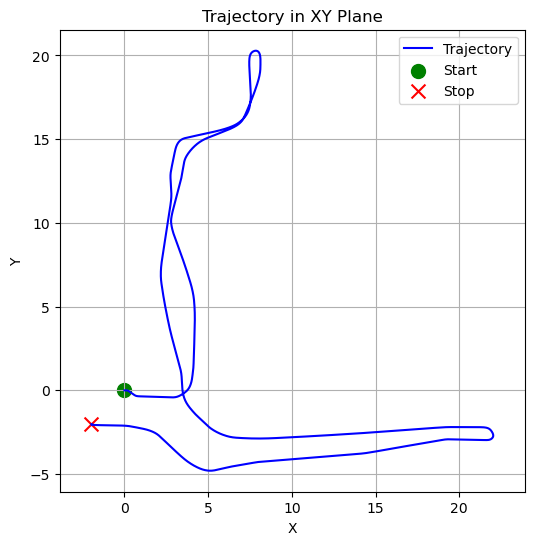

In [10]:

import matplotlib.pyplot as plt

def plot_trajectory(poses, additional_poses=None, title="Trajectory in XY Plane"):
    """
    Plots the trajectory of a sequence of poses in the XY plane.

    Parameters:
    - poses: A list or array of transformation matrices (4x4).
    - additional_poses: An optional list or array of transformation matrices (4x4) for the second trajectory to be plotted in orange.
    - title: Title for the plot (default: "Trajectory in XY Plane").
    """
    xy_positions = np.array([[pose[0, 3], pose[1, 3]] for pose in poses])
    
    plt.figure(figsize=(6, 6))
    
    # Plot the primary trajectory
    plt.plot(xy_positions[:, 0], xy_positions[:, 1], label='Trajectory', color='blue')
    plt.scatter(xy_positions[0, 0], xy_positions[0, 1], color='green', label='Start', s=100, marker='o')
    plt.scatter(xy_positions[-1, 0], xy_positions[-1, 1], color='red', label='Stop', s=100, marker='x')

    if additional_poses is not None:
        additional_xy_positions = np.array([[pose[0, 3], pose[1, 3]] for pose in additional_poses])
        plt.plot(additional_xy_positions[:, 0], additional_xy_positions[:, 1], label='Additional Trajectory', color='orange')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(title)
    plt.grid(True)
    plt.axis('equal')  # Ensure equal scaling on both axes.
    plt.legend()
    plt.show()

plot_trajectory(encoder_poses)

In [11]:
def get_lidar_pc(lidar_raw_vals,  lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment):
    lidar_angles= np.linspace(lidar_angle_min, lidar_angle_max, int((lidar_angle_max - lidar_angle_min) / lidar_angle_increment) + 1)
    lidar_val_mask = np.where((lidar_raw_vals > lidar_range_min) & (lidar_raw_vals < lidar_range_max), True, False)
    lidar_raw_vals_masked = lidar_raw_vals[lidar_val_mask]
    lidar_angles_masked = lidar_angles[lidar_val_mask]
    lidar_x = lidar_raw_vals_masked * np.cos(lidar_angles_masked) 
    lidar_y = lidar_raw_vals_masked * np.sin(lidar_angles_masked)
    lidar_z = np.zeros(lidar_raw_vals_masked.shape[0])
    return np.column_stack((lidar_x,lidar_y,lidar_z))

In [12]:
# pc=get_lidar_pc(lidar_ranges[:,0],  lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment[0,0])

In [13]:
import ICP_stuff
from tqdm import tqdm

prev_pose= T_0
accumulated_pose= T_0
lidarToBodyPose = ICP_stuff.get_pose(np.identity(3), np.array([0.13323,0,0.51435]))
trajectory= []
for idx in tqdm(range(encoder_ts.shape[0]-1)):
    # Time t data
    enc_ts_t= encoder_ts[idx]
    lidar_pc_at_t = get_lidar_pc(lidar_ranges[:,lidar_sync_map[enc_ts_t]],  lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment[0,0])
    
    # Time T+1 data
    enc_ts_t1 = encoder_ts[idx+1]
    lidar_pc_at_t1= get_lidar_pc(lidar_ranges[:,lidar_sync_map[enc_ts_t1]],  lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment[0,0])
    
    # motion model
    del_T = enc_ts_t1- enc_ts_t
    motion_model_pose = motion_model(prev_pose, lin_vel=robo_vel[ii], angular_vel=imu_angular[:,imu_sync_map[encoder_ts[ii]]], del_T=del_T  )
    icp_pose= ICP_stuff.ICP(lidar_pc_at_t1,lidar_pc_at_t, motion_model_pose)
    
    accumulated_pose= accumulated_pose@icp_pose
    trajectory.append(accumulated_pose)


  0%|          | 5/4955 [00:02<47:23,  1.74it/s]  


KeyboardInterrupt: 

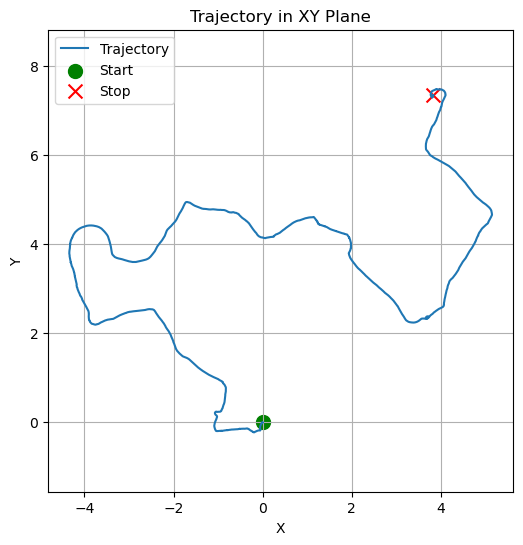

In [85]:
plot_trajectory(trajectory)

In [14]:
import ICP_stuff
from tqdm import tqdm
accumulated_pose = np.identity(4)
icp_traj = []
relative_poses=[]
lidar_body_pose = ICP_stuff.get_pose(np.identity(3), np.array([0.13323,0,0.51435]))

for idx in tqdm(range(encoder_ts.shape[-1]-1)):
    enc_ts_at_t = encoder_ts[idx]
    enc_ts_at_t1 = encoder_ts[idx+1]
    encoder_pred_poses = encoder_poses[idx]

    # LTDAW stuff at time t
    lidar_range_val_at_t = lidar_ranges[:, lidar_sync_map[enc_ts_at_t]]
    lidar_pc_at_t = get_lidar_pc(lidar_range_val_at_t, lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment[0,0])
    pose_at_t = encoder_poses[idx] @ lidar_body_pose

    # LTDAW stuff at time t+1
    lidar_range_val_at_t1 = lidar_ranges[:, lidar_sync_map[enc_ts_at_t1]]  
    lidar_pc_at_t1 = get_lidar_pc(lidar_range_val_at_t1,lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment[0,0])
    pose_at_t1 = encoder_poses[idx+1] @ lidar_body_pose

    init_pose_for_ICP = np.linalg.inv(pose_at_t) @ pose_at_t1

    icp_estimated_pose = ICP_stuff.ICP(lidar_pc_at_t, lidar_pc_at_t1, init_pose_for_ICP)

    accumulated_pose = accumulated_pose @ icp_estimated_pose
    relative_poses.append(icp_estimated_pose)
    icp_traj.append(accumulated_pose)

icp_traj = np.array(icp_traj)
relative_poses = np.array(relative_poses)

100%|██████████| 4955/4955 [01:51<00:00, 44.59it/s]


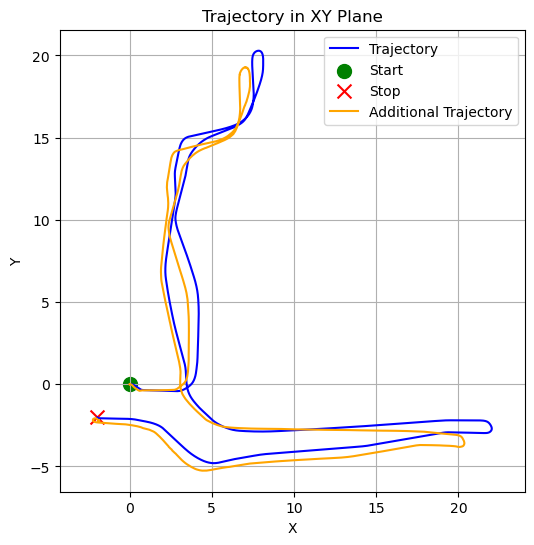

In [15]:
plot_trajectory(encoder_poses,icp_traj)

# occupancy grid

In [16]:
import numpy as np
import pr2_utils
# Initialize a grid map
MAP = {}
MAP['res'] = np.array([0.05, 0.05])    # meters
MAP['min'] = np.array([-20.0, -20.0])  # meters
MAP['max'] = np.array([30.0, 30.0])    # meters
MAP['size'] = np.ceil((MAP['max'] - MAP['min']) / MAP['res']).astype(int)
isEven = MAP['size']%2==0
MAP['size'][isEven] = MAP['size'][isEven]+1 # Make sure that the map has an odd size so that the origin is in the center cell
MAP['map'] = np.zeros(MAP['size'])

In [17]:
def get_map_coords(xy, MAP):
    return np.floor((xy - MAP['min']) / MAP['res']).astype(int)

In [18]:
for idx in tqdm(range(encoder_ts.shape[-1]-1)):
    enc_ts = encoder_ts[idx]
    curr_pose= icp_traj[idx] @ lidar_body_pose
    
    curr_R, curr_p= ICP_stuff.get_R_and_P(curr_pose)

    lidar_range_val = lidar_ranges[:, lidar_sync_map[enc_ts]]
    lidar_pc= get_lidar_pc(lidar_range_val, lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment[0,0])
    
    lidar_pc= ICP_stuff.rotate_pc(R=curr_R, pc=lidar_pc)+curr_p
    
    lidar_xy_pts= lidar_pc[:,:2]

    lidar_grid_pts= get_map_coords(lidar_xy_pts, MAP)-1
    
    lidar_grid_x= lidar_grid_pts[:,0]
    lidar_grid_y= lidar_grid_pts[:,1]

    start_pt=get_map_coords(curr_p[:2],MAP)

    for ii in range(lidar_grid_x.shape[0]):
        x,y = pr2_utils.bresenham2D(start_pt[0],start_pt[1], lidar_grid_x[ii], lidar_grid_y[ii])
        MAP['map'][y.astype(np.int32)[:-1], x.astype(np.int32)[:-1]] -= np.log(4)

    MAP['map'][lidar_grid_y, lidar_grid_x] += np.log(4)

    MAP['map'][np.where(MAP['map'] < -4*np.log(4))] = -4*np.log(4)
    MAP['map'][np.where(MAP['map'] > 4*np.log(4))] = 4*np.log(4)

100%|██████████| 4955/4955 [06:19<00:00, 13.05it/s]


In [19]:
# plt.figure(figsize=(10, 10))
# plt.title('Occupancy Grid')
# plt.imshow(1/(1+np.exp(-MAP['map'])), cmap='gray')
# plt.savefig('./outputs/LiDAR_scan_dt_{}.jpg'.format(dataset_idx))
# # plt.close()

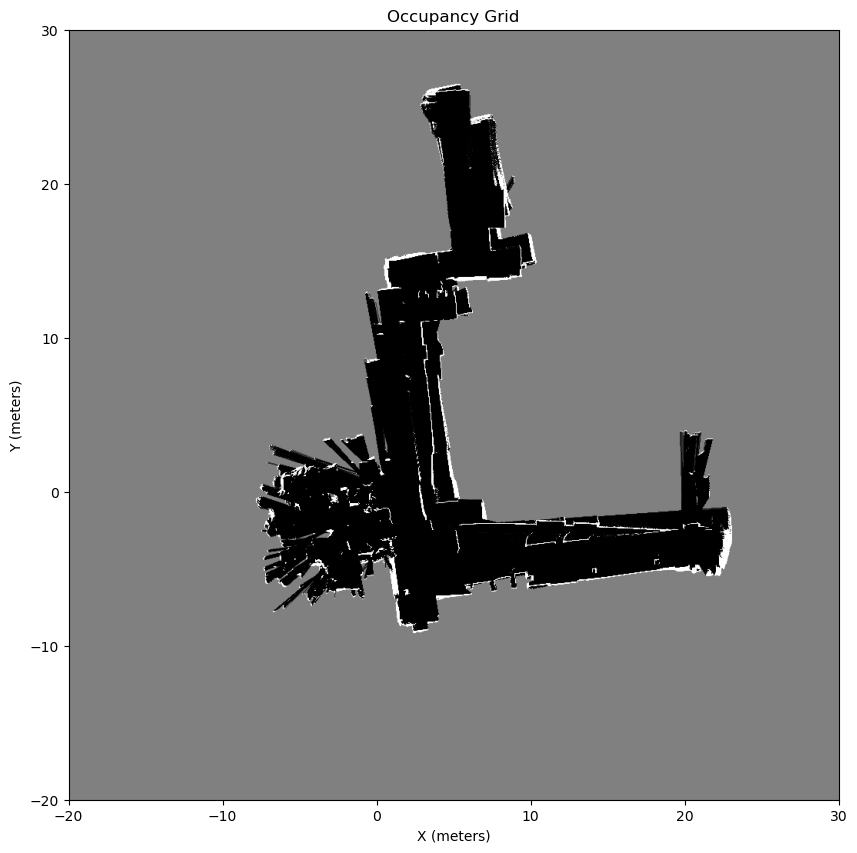

In [20]:
plt.figure(figsize=(10, 10))
plt.title('Occupancy Grid')

plt.imshow(1/(1+np.exp(-MAP['map'])), cmap='gray', origin='lower', extent=[MAP['min'][0], MAP['max'][0], MAP['min'][1], MAP['max'][1]])

# Set axis labels with scale information
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")

# Save and display
plt.savefig('./outputs/occupancy_grid_{}.jpg'.format(dataset_idx))
plt.show()


# texture Mapping


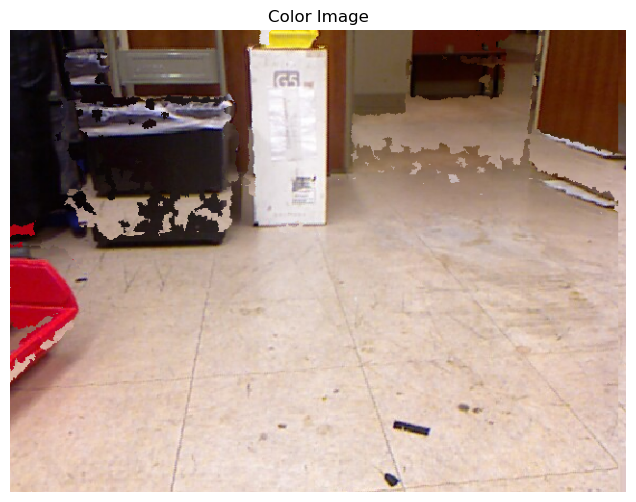

True

In [23]:
import numpy as np
import cv2
import open3d as o3d

# generate sample pc from disparity images

# IMREAD_UNCHANGED ensures we preserve the precision on depth
disp_img = cv2.imread("../data/dataRGBD/Disparity20/disparity20_1.png", cv2.IMREAD_UNCHANGED)

# note that cv2 imports as bgr, so colors may be wrong.
bgr_img = cv2.imread("../data/dataRGBD/RGB20/rgb20_1.png")
rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)

# from writeup, compute correspondence
height, width = disp_img.shape

dd = np.array(-0.00304 * disp_img + 3.31)
depth = 1.03 / dd

mesh = np.meshgrid(np.arange(0, height), np.arange(0, width), indexing='ij')  
i_idxs = mesh[0].flatten()
j_idxs = mesh[1].flatten()

rgb_i = np.array((526.37 * i_idxs + 19276 - 7877.07 * dd.flatten()) / 585.051, dtype=np.int32)  # force int for indexing
rgb_j = np.array((526.37 * j_idxs + 16662) / 585.051, dtype=np.int32)

# some may be out of bounds, just clip them
rgb_i = np.clip(rgb_i, 0, height - 1)
rgb_j = np.clip(rgb_j, 0, width - 1)

colors = rgb_img[rgb_i, rgb_j]

# lets visualize the image using our transformation to make sure things look correct (using bgr for opencv)
bgr_colors = bgr_img[rgb_i, rgb_j]
# cv2.imshow("color", bgr_colors.reshape((height, width, 3)))
# Convert BGR to RGB if using OpenCV
rgb_colors = bgr_colors.reshape((height, width, 3))[:, :, ::-1]  # Swap channels from BGR to RGB

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(rgb_colors)
plt.axis("off")  # Hide axes
plt.title("Color Image")
plt.show()

uv1 = np.vstack([j_idxs, i_idxs, np.ones_like(i_idxs)])
K = np.array([[585.05, 0, 242.94],
              [0, 585.05, 315.84],
              [0, 0, 1]])

# project images to 3d points
points = depth.flatten() * (np.linalg.inv(K) @ uv1)

oRr = np.array([[0, -1, 0],
                [0, 0, -1],
                [1, 0, 0]])
# we want rRo because we have points in optical frame and want to move them to the regular frame.
points = oRr.T @ points

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points.T)
pcd.colors = o3d.utility.Vector3dVector(colors / 255)  # open3d expects color channels 0-1, opencv uses uint8 0-255

origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=.5)  # visualize the camera regular frame for reference.
# o3d.visualization.draw([pcd, origin])  # display the pointcloud and origin
o3d.io.write_point_cloud("/home/bradhakrishnan/ECE276A_PR2/code/open_3d plots/point_cloud.ply", pcd)



In [21]:
import ICP_stuff
import transforms3d as t3d

# Initialize a grid map
TEXTURE_MAP = {}
TEXTURE_MAP['res'] = np.array([0.05, 0.05])    # meters
TEXTURE_MAP['min'] = np.array([-20.0, -20.0])  # meters
TEXTURE_MAP['max'] = np.array([30.0, 30.0])    # meters
TEXTURE_MAP['size'] = np.ceil((TEXTURE_MAP['max'] - TEXTURE_MAP['min']) / TEXTURE_MAP['res']).astype(int)
isEven = TEXTURE_MAP['size']%2==0
TEXTURE_MAP['size'][isEven] = TEXTURE_MAP['size'][isEven]+1 # Make sure that the map has an odd size so that the origin is in the center cell
TEXTURE_MAP['map'] = np.zeros((TEXTURE_MAP['size'][0], TEXTURE_MAP['size'][1], 3))

In [119]:
for idx in tqdm(range(encoder_ts.shape[0]-1)):
    
    icp_pose= icp_traj[idx]
    enc_ts = encoder_ts[idx]
    
    rgb_file_num= rgb_sync_map[enc_ts]+1
    bgr_img = cv2.imread(f"../data/dataRGBD/RGB{dataset_idx}/rgb{dataset_idx}_{rgb_file_num}.png")
    rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    disp_file_num = disp_sync_map[enc_ts]+1
    disp_img = cv2.imread(f"../data/dataRGBD/Disparity{dataset_idx}/disparity{dataset_idx}_{disp_file_num}.png", cv2.IMREAD_UNCHANGED)
    height, width = disp_img.shape
    dd = np.array(-0.00304 * disp_img + 3.31)
    depth = 1.03 / dd

    mesh = np.meshgrid(np.arange(0, height), np.arange(0, width), indexing='ij')  
    i_idxs = mesh[0].flatten()
    j_idxs = mesh[1].flatten()
    
    rgb_i = np.array((526.37 * i_idxs + 19276 - 7877.07 * dd.flatten()) / 585.051, dtype=np.int32)  # force int for indexing
    rgb_j = np.array((526.37 * j_idxs + 16662) / 585.051, dtype=np.int32)

    # some may be out of bounds, just clip them
    rgb_i = np.clip(rgb_i, 0, height - 1)
    rgb_j = np.clip(rgb_j, 0, width - 1)
    
    colors = rgb_img[rgb_i, rgb_j]
    # colors = colors / 255
    uv1 = np.vstack([j_idxs, i_idxs, np.ones_like(i_idxs)])

    K = np.array([[585.05, 0, 242.94],
              [0, 585.05, 315.84],
              [0, 0, 1]])
 
    uv1= depth.flatten() * (np.linalg.inv(K) @ uv1) # rotate the given point by K^-1
    oRr = np.array([[0, -1, 0],
                [0, 0, -1],
                [1, 0, 0]])
    # we want rRo because we have points in optical frame and want to move them to the regular frame.
    points = oRr.T @ uv1
    points_homogeneous = np.vstack([points, np.ones(points.shape[1])])
    # now do cam -> body stuff
    cam2body_p= np.array([0.18,0.005,0.36])
    cam2body_R = t3d.euler.euler2mat(0,0.36,0.021)
    cam2body_T= ICP_stuff.get_pose(cam2body_R, cam2body_p)
    points_body = cam2body_T @ points_homogeneous
    

    points_world = icp_pose @ points_body
    uv_body_xy = points_world[:2, :].T
    uv_body_z = points_world[2, :]

    norms = np.linalg.norm(points_world[:3, :], axis=0)
    
    valid_indices = np.where((uv_body_z < 0.5))

    # if valid_indices[0].shape[0] ==0:
    #     import ipdb; ipdb.set_trace()
    #     print(valid_indices)
    uv_body_xy = uv_body_xy[valid_indices]
    colors = colors[valid_indices]/255.0

    # Map world coordinates to grid indices
    grid_xy = np.round((uv_body_xy - TEXTURE_MAP['min']) / TEXTURE_MAP['res']).astype(int)
    grid_x, grid_y = grid_xy[:, 0], grid_xy[:, 1]

    # Filter valid grid indices
    valid_mask = (grid_x >= 0) & (grid_x < TEXTURE_MAP['size'][0]) & \
                 (grid_y >= 0) & (grid_y < TEXTURE_MAP['size'][1])
    grid_x, grid_y, colors = grid_x[valid_mask], grid_y[valid_mask], colors[valid_mask]

    # Update the texture map
    TEXTURE_MAP['map'][grid_y, grid_x] = colors
    # texture_map_xy = get_map_coords(uv_body_xy, TEXTURE_MAP)
    # TEXTURE_MAP['map'][texture_map_xy[:,1], texture_map_xy[:,0], :] = colors
    if idx==10:
        continue

100%|██████████| 4955/4955 [10:38<00:00,  7.76it/s]


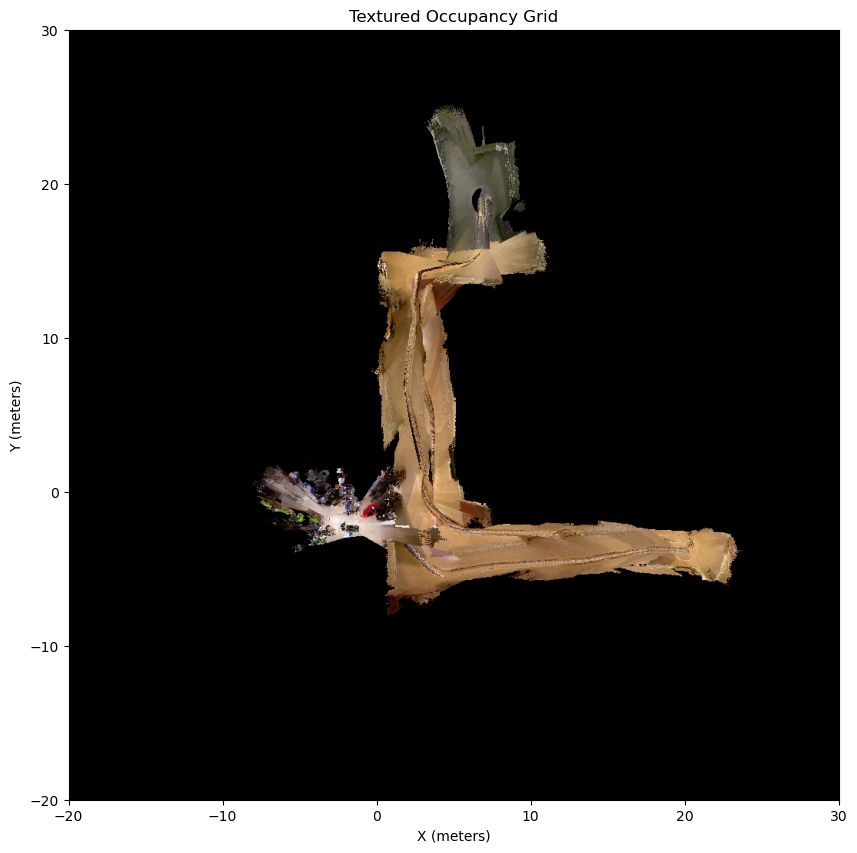

In [120]:
import datetime

plt.figure(figsize=(10, 10))
plt.title('Textured Occupancy Grid')
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

plt.imshow(TEXTURE_MAP['map'], origin='lower', extent=[TEXTURE_MAP['min'][0], TEXTURE_MAP['max'][0], TEXTURE_MAP['min'][1], TEXTURE_MAP['max'][1]])

# Set axis labels with scale information
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")

# Save and display
plt.savefig('./outputs/Textured_occupancy_{}_{}.jpg'.format(dataset_idx, timestamp))
plt.show()

In [110]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_world[:3, :].T[valid_indices])
pcd.colors = o3d.utility.Vector3dVector(colors)  # open3d expects color channels 0-1, opencv uses uint8 0-255

origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=.5)  # visualize the camera regular frame for reference.

# o3d.visualization.draw([pcd, origin])  # display the pointcloud and origin
o3d.io.write_point_cloud("/home/bradhakrishnan/ECE276A_PR2/code/open_3d plots/point_cloud_dum.ply", pcd)

True

In [ ]:
plt.imshow(rgb_img)

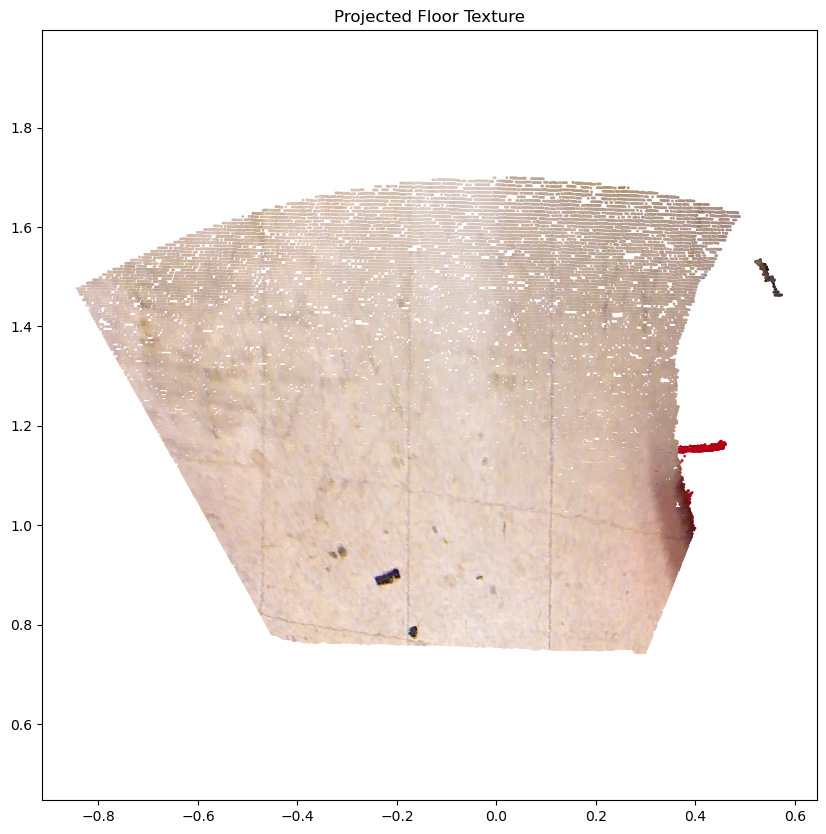

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(uv_body_xy[:, 1],uv_body_xy[:, 0],c=colors, s=1)  # Small dots for density
plt.title("Projected Floor Texture")
plt.axis("equal")  # Preserve aspect ratio
plt.show()


# GTSAM !!!

In [23]:
import gtsam
from gtsam import Pose3, Rot3, Point3


In [24]:
def matrix_to_pose3(T):
    R, p = ICP_stuff.get_R_and_P(T)
    return Pose3(Rot3(R), Point3(p))

In [21]:
poses = encoder_poses          # List of 4x4 absolute transformation matrices
relative_poses = relative_poses  # List of 4x4 relative transformations (ICP-based)

# Define noise models
prior_noise = gtsam.noiseModel.Diagonal.Sigmas([0.01, 0.01, 0.01, 0.01, 0.01, 0.01])  # Small uncertainty
odometry_noise = gtsam.noiseModel.Diagonal.Sigmas([0.1, 0.1, 0.1, 0.1, 0.1, 0.1])  # Odometry uncertainty


In [49]:
import gtsam
import numpy as np
from gtsam import Pose3, Rot3, Point3

# Initialize the Factor Graph
graph = gtsam.NonlinearFactorGraph()
initial_estimate = gtsam.Values()

# Step 1: Add the first node with a prior factor
first_pose = matrix_to_pose3(poses[0])
graph.add(gtsam.PriorFactorPose3(0, first_pose, prior_noise))
initial_estimate.insert(0, first_pose)

# Step 2: Add odometry factors (edges)
for i in range(1, len(poses)):
    relative_pose = matrix_to_pose3(relative_poses[i-1])  # Convert relative transform to Pose3
    graph.add(gtsam.BetweenFactorPose3(i-1, i, relative_pose, odometry_noise))  # Add edge
    initial_estimate.insert(i, matrix_to_pose3(poses[i]))  # Insert absolute pose

# Step 3: Optimize the Graph
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimate)
result = optimizer.optimize()

In [50]:
optimized_poses = []

for i in range(len(poses)):  # Iterate over all pose indices
    optimized_pose = result.atPose3(i)  # Get optimized Pose3
    T = np.eye(4)  # Initialize 4x4 matrix

    # Extract rotation and translation from Pose3
    T[:3, :3] = optimized_pose.rotation().matrix()
    T[:3, 3] = optimized_pose.translation()

    optimized_poses.append(T)

# Now, optimized_poses is a list of 4x4 matrices
optimized_poses= np.array(optimized_poses)

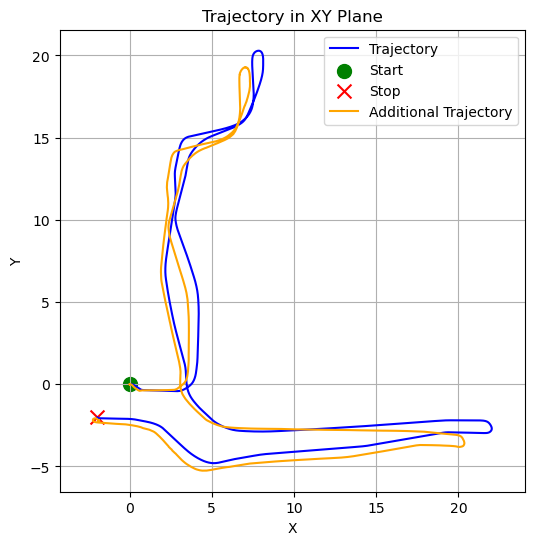

In [51]:
plot_trajectory(encoder_poses , optimized_poses)

# Fixed-interval loop closure

In [84]:
# Initialize the Factor Graph

fixed_interval = 10
lidar_body_pose = ICP_stuff.get_pose(np.identity(3), np.array([0.13323,0,0.51435]))
factor_graph = gtsam.NonlinearFactorGraph()
initial_estimate = gtsam.Values()

# Step 1: Add the first node with a prior factor
first_pose = matrix_to_pose3(poses[0])
factor_graph.add(gtsam.PriorFactorPose3(0, first_pose, prior_noise))
initial_estimate.insert(0, first_pose)

# Step 2: Add odometry factors (edges)
for i in tqdm(range(1, len(poses))):
    relative_pose = matrix_to_pose3(relative_poses[i-1])  # Convert relative transform to Pose3
    factor_graph.add(gtsam.BetweenFactorPose3(i-1, i, relative_pose, odometry_noise))  # Add edge
    initial_estimate.insert(i, matrix_to_pose3(poses[i]))  # Insert absolute pose..

    if i%fixed_interval==0:
        # We need to add loop closure
        curr_ts= encoder_ts[i] 
        prev_10_ts= encoder_ts[i-fixed_interval]

        curr_lidar_pc= get_lidar_pc(lidar_ranges[:,lidar_sync_map[curr_ts]],  lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment[0,0])
        prev_10_lidar_pc= get_lidar_pc(lidar_ranges[:,lidar_sync_map[prev_10_ts]],  lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment[0,0])
        curr_pose=(poses[i]@lidar_body_pose)
        prev_10_pose= (poses[i-fixed_interval]@lidar_body_pose)

        init_pose_for_ICP = np.linalg.inv(prev_10_pose) @ curr_pose
        ICP_pred_pose = ICP_stuff.ICP(source_pc= prev_10_lidar_pc, target_pc=curr_lidar_pc  , init_T=init_pose_for_ICP)
        ICP_pred_pose=matrix_to_pose3(ICP_pred_pose) 
        factor_graph.add(gtsam.BetweenFactorPose3(i-fixed_interval, i, ICP_pred_pose, odometry_noise))
        

100%|██████████| 4955/4955 [00:16<00:00, 304.71it/s]


In [85]:
# Step 3: Optimize the Graph
params = gtsam.LevenbergMarquardtParams()
params.setMaxIterations(1000)
optimizer = gtsam.LevenbergMarquardtOptimizer(factor_graph, initial_estimate, params)
result = optimizer.optimize()

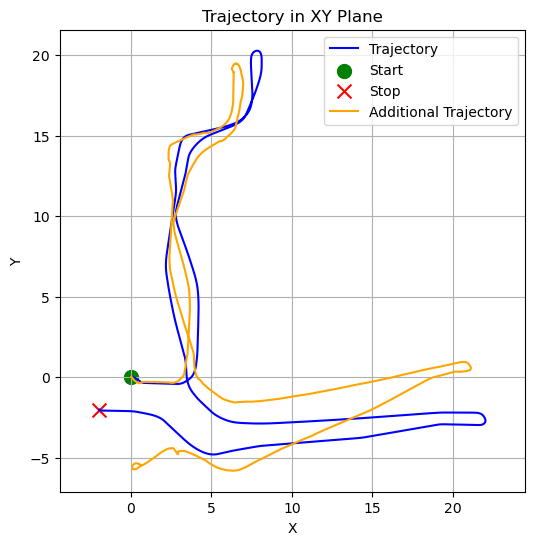

In [86]:
optimized_poses = []

for i in range(len(poses)):  # Iterate over all pose indices
    optimized_pose = result.atPose3(i)  # Get optimized Pose3
    T = np.eye(4)  # Initialize 4x4 matrix

    # Extract rotation and translation from Pose3
    T[:3, :3] = optimized_pose.rotation().matrix()
    T[:3, 3] = optimized_pose.translation()

    optimized_poses.append(T)

# Now, optimized_poses is a list of 4x4 matrices
optimized_poses= np.array(optimized_poses)
plot_trajectory(encoder_poses , optimized_poses)

# Proximity GTSAM

In [28]:
def find_translation_diff(T1, T2):
    return np.linalg.norm(T1[:3, 3]-T2[:3, 3])

In [70]:
# Initialize the Factor Graph

fixed_interval = 20
lidar_body_pose = ICP_stuff.get_pose(np.identity(3), np.array([0.13323,0,0.51435]))
factor_graph = gtsam.NonlinearFactorGraph()
initial_estimate = gtsam.Values()

# Step 1: Add the first node with a prior factor
first_pose = matrix_to_pose3(poses[0])
factor_graph.add(gtsam.PriorFactorPose3(0, first_pose, prior_noise))
initial_estimate.insert(0, first_pose)

# Step 2: Add odometry factors (edges)
for i in tqdm(range(1, len(poses))):
    relative_pose = matrix_to_pose3(relative_poses[i-1])  # Convert relative transform to Pose3
    factor_graph.add(gtsam.BetweenFactorPose3(i-1, i, relative_pose, odometry_noise))  # Add edge
    initial_estimate.insert(i, matrix_to_pose3(poses[i]))  # Insert absolute pose..
    
    if i%fixed_interval==0:
        # We need to add loop closure
        curr_ts= encoder_ts[i] 
        curr_lidar_pc= get_lidar_pc(lidar_ranges[:,lidar_sync_map[curr_ts]],  lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment[0,0])
        curr_pose=(poses[i]@lidar_body_pose)

        prev_10_ts= encoder_ts[i-fixed_interval]
        prev_10_lidar_pc= get_lidar_pc(lidar_ranges[:,lidar_sync_map[prev_10_ts]],  lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment[0,0])
        prev_10_pose= (poses[i-fixed_interval]@lidar_body_pose)

        init_pose_for_ICP = np.linalg.inv(prev_10_pose) @ curr_pose
        ICP_pred_pose = ICP_stuff.ICP(source_pc= prev_10_lidar_pc, target_pc= curr_lidar_pc, init_T=init_pose_for_ICP)
        ICP_pred_pose=matrix_to_pose3(ICP_pred_pose) 
        factor_graph.add(gtsam.BetweenFactorPose3(i-fixed_interval, i, ICP_pred_pose, odometry_noise))

        
        dists=[find_translation_diff(curr_pose, p) for p in poses]
        dists = np.array(dists)
        proximity_threshold_max = 2
        proximity_indices = np.where((0 < dists) &(dists <proximity_threshold_max))[0]
        proximity_indices = proximity_indices[(proximity_indices < i-250) | (proximity_indices > i+250)]

        print(len(proximity_indices))
        for idx in proximity_indices:
            proximity_ts= encoder_ts[idx]
            proximity_lidar_pc= get_lidar_pc(lidar_ranges[:,lidar_sync_map[proximity_ts]],  lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment[0,0])
            proximity_pose =  (poses[idx]@lidar_body_pose)
            init_pose_for_ICP = np.linalg.inv(curr_pose) @ proximity_pose
        
            ICP_pred_pose = ICP_stuff.ICP(source_pc= proximity_lidar_pc, target_pc= curr_lidar_pc, init_T=init_pose_for_ICP)
            ICP_pred_pose=matrix_to_pose3(ICP_pred_pose) 
            factor_graph.add(gtsam.BetweenFactorPose3(idx, i, ICP_pred_pose, odometry_noise))        

  0%|          | 0/4955 [00:00<?, ?it/s]

391


  0%|          | 20/4955 [00:13<54:38,  1.51it/s]

371


  1%|          | 40/4955 [00:25<50:52,  1.61it/s]

351


  1%|          | 60/4955 [00:36<48:08,  1.69it/s]

331


  2%|▏         | 80/4955 [00:46<45:26,  1.79it/s]

311


  2%|▏         | 100/4955 [00:56<44:04,  1.84it/s]

291


  2%|▏         | 120/4955 [01:06<42:01,  1.92it/s]

271


  3%|▎         | 140/4955 [01:15<40:16,  1.99it/s]

251


  3%|▎         | 160/4955 [01:24<38:27,  2.08it/s]

231


  4%|▎         | 180/4955 [01:32<36:19,  2.19it/s]

211


  4%|▍         | 200/4955 [01:39<33:39,  2.35it/s]

191


  4%|▍         | 220/4955 [01:46<31:15,  2.52it/s]

171


  5%|▍         | 240/4955 [01:51<28:20,  2.77it/s]

161


  5%|▌         | 260/4955 [01:57<26:03,  3.00it/s]

161


  6%|▌         | 280/4955 [02:02<24:19,  3.20it/s]

161


  6%|▌         | 300/4955 [02:07<22:43,  3.41it/s]

161


  6%|▋         | 320/4955 [02:11<21:03,  3.67it/s]

161


  7%|▋         | 340/4955 [02:16<20:02,  3.84it/s]

161


  7%|▋         | 360/4955 [02:20<18:55,  4.05it/s]

161


  8%|▊         | 380/4955 [02:24<18:01,  4.23it/s]

164


  8%|▊         | 400/4955 [02:30<19:07,  3.97it/s]

170


  8%|▊         | 420/4955 [02:36<19:35,  3.86it/s]

190


  9%|▉         | 440/4955 [02:42<20:50,  3.61it/s]

210


  9%|▉         | 460/4955 [02:51<24:44,  3.03it/s]

230


 10%|▉         | 480/4955 [02:59<26:25,  2.82it/s]

250


 10%|█         | 500/4955 [03:18<39:31,  1.88it/s]

309


 10%|█         | 520/4955 [03:36<47:18,  1.56it/s]

339


 11%|█         | 540/4955 [03:51<49:39,  1.48it/s]

355


 11%|█▏        | 560/4955 [04:05<49:51,  1.47it/s]

367


 12%|█▏        | 580/4955 [04:14<44:26,  1.64it/s]

368


 12%|█▏        | 600/4955 [04:24<42:15,  1.72it/s]

370


 13%|█▎        | 620/4955 [04:37<42:54,  1.68it/s]

456


 13%|█▎        | 640/4955 [04:52<46:01,  1.56it/s]

93


 13%|█▎        | 660/4955 [04:58<38:39,  1.85it/s]

113


 14%|█▎        | 680/4955 [05:06<35:10,  2.03it/s]

128


 14%|█▍        | 700/4955 [05:12<31:06,  2.28it/s]

143


 15%|█▍        | 720/4955 [05:18<28:31,  2.47it/s]

151


 15%|█▍        | 740/4955 [05:26<27:44,  2.53it/s]

157


 15%|█▌        | 760/4955 [05:36<30:12,  2.31it/s]

162


 16%|█▌        | 780/4955 [05:46<31:23,  2.22it/s]

163


 16%|█▌        | 800/4955 [05:57<32:45,  2.11it/s]

159


 17%|█▋        | 820/4955 [06:07<33:51,  2.04it/s]

152


 17%|█▋        | 840/4955 [06:15<32:01,  2.14it/s]

143


 17%|█▋        | 860/4955 [06:21<28:17,  2.41it/s]

130


 18%|█▊        | 880/4955 [06:26<24:45,  2.74it/s]

120


 18%|█▊        | 900/4955 [06:30<21:15,  3.18it/s]

114


 19%|█▊        | 920/4955 [06:34<18:38,  3.61it/s]

110


 19%|█▉        | 940/4955 [06:37<16:18,  4.10it/s]

101


 19%|█▉        | 960/4955 [06:40<14:13,  4.68it/s]

90


 20%|█▉        | 980/4955 [06:42<12:10,  5.44it/s]

78


 20%|██        | 1000/4955 [06:45<10:32,  6.26it/s]

65


 21%|██        | 1020/4955 [06:46<08:54,  7.37it/s]

55


 21%|██        | 1040/4955 [06:47<07:26,  8.77it/s]

53


 21%|██▏       | 1060/4955 [06:49<06:23, 10.15it/s]

67


 22%|██▏       | 1080/4955 [06:51<06:39,  9.70it/s]

90


 22%|██▏       | 1100/4955 [06:56<09:07,  7.04it/s]

106


 23%|██▎       | 1120/4955 [07:01<11:35,  5.51it/s]

115


 23%|██▎       | 1140/4955 [07:07<14:10,  4.48it/s]

121


 23%|██▎       | 1160/4955 [07:14<15:50,  3.99it/s]

127


 24%|██▍       | 1180/4955 [07:20<17:10,  3.66it/s]

132


 24%|██▍       | 1200/4955 [07:25<16:50,  3.72it/s]

135


 25%|██▍       | 1220/4955 [07:32<17:38,  3.53it/s]

138


 25%|██▌       | 1240/4955 [07:38<18:14,  3.40it/s]

144


 25%|██▌       | 1260/4955 [07:43<17:28,  3.52it/s]

144


 26%|██▌       | 1280/4955 [07:49<16:59,  3.60it/s]

143


 26%|██▌       | 1300/4955 [07:55<17:43,  3.44it/s]

148


 27%|██▋       | 1320/4955 [08:02<18:44,  3.23it/s]

190


 27%|██▋       | 1340/4955 [08:11<20:52,  2.89it/s]

201


 27%|██▋       | 1360/4955 [08:21<23:37,  2.54it/s]

201


 28%|██▊       | 1380/4955 [08:31<25:10,  2.37it/s]

194


 28%|██▊       | 1400/4955 [08:41<26:43,  2.22it/s]

190


 29%|██▊       | 1420/4955 [08:49<26:03,  2.26it/s]

186


 29%|██▉       | 1440/4955 [08:58<25:31,  2.30it/s]

170


 29%|██▉       | 1460/4955 [09:05<23:40,  2.46it/s]

156


 30%|██▉       | 1480/4955 [09:13<23:47,  2.43it/s]

162


 30%|███       | 1500/4955 [09:20<22:21,  2.58it/s]

165


 31%|███       | 1520/4955 [09:27<21:34,  2.65it/s]

166


 31%|███       | 1540/4955 [09:34<21:10,  2.69it/s]

170


 31%|███▏      | 1560/4955 [09:43<22:13,  2.55it/s]

170


 32%|███▏      | 1580/4955 [09:50<21:56,  2.56it/s]

132


 32%|███▏      | 1600/4955 [09:57<20:26,  2.74it/s]

84


 33%|███▎      | 1620/4955 [10:00<16:44,  3.32it/s]

38


 35%|███▍      | 1720/4955 [10:01<04:06, 13.11it/s]

0
0
0
0


 36%|███▋      | 1800/4955 [10:01<01:46, 29.51it/s]

0
0
0
0
0
12


 37%|███▋      | 1840/4955 [10:02<01:40, 31.13it/s]

55


 38%|███▊      | 1860/4955 [10:06<03:08, 16.41it/s]

101


 38%|███▊      | 1880/4955 [10:10<04:26, 11.52it/s]

141


 38%|███▊      | 1900/4955 [10:14<05:52,  8.66it/s]

154


 39%|███▊      | 1920/4955 [10:19<07:34,  6.67it/s]

153


 39%|███▉      | 1940/4955 [10:27<10:49,  4.64it/s]

155


 40%|███▉      | 1960/4955 [10:34<12:17,  4.06it/s]

160


 40%|███▉      | 1980/4955 [10:41<13:35,  3.65it/s]

164


 40%|████      | 2000/4955 [10:46<13:40,  3.60it/s]

165


 41%|████      | 2020/4955 [10:52<13:38,  3.59it/s]

159


 41%|████      | 2040/4955 [11:00<15:10,  3.20it/s]

155


 42%|████▏     | 2060/4955 [11:08<16:21,  2.95it/s]

146


 42%|████▏     | 2080/4955 [11:16<17:16,  2.77it/s]

134


 42%|████▏     | 2100/4955 [11:23<17:15,  2.76it/s]

130


 43%|████▎     | 2120/4955 [11:32<18:09,  2.60it/s]

130


 43%|████▎     | 2140/4955 [11:37<16:06,  2.91it/s]

136


 44%|████▎     | 2160/4955 [11:45<17:00,  2.74it/s]

141


 44%|████▍     | 2180/4955 [11:52<16:21,  2.83it/s]

142


 44%|████▍     | 2200/4955 [12:02<18:15,  2.51it/s]

144


 45%|████▍     | 2220/4955 [12:09<17:16,  2.64it/s]

144


 45%|████▌     | 2240/4955 [12:16<17:09,  2.64it/s]

145


 46%|████▌     | 2260/4955 [12:22<16:07,  2.79it/s]

147


 46%|████▌     | 2280/4955 [12:28<14:40,  3.04it/s]

143


 46%|████▋     | 2300/4955 [12:34<14:21,  3.08it/s]

139


 47%|████▋     | 2320/4955 [12:41<14:51,  2.96it/s]

137


 47%|████▋     | 2340/4955 [12:47<13:50,  3.15it/s]

130


 48%|████▊     | 2360/4955 [12:51<12:36,  3.43it/s]

120


 48%|████▊     | 2380/4955 [12:55<11:15,  3.81it/s]

104


 48%|████▊     | 2400/4955 [12:58<09:55,  4.29it/s]

89


 49%|████▉     | 2420/4955 [13:02<08:48,  4.80it/s]

78


 49%|████▉     | 2440/4955 [13:04<07:40,  5.46it/s]

71


 50%|████▉     | 2460/4955 [13:06<06:28,  6.42it/s]

69


 50%|█████     | 2480/4955 [13:08<05:44,  7.18it/s]

71


 50%|█████     | 2500/4955 [13:11<06:02,  6.78it/s]

75


 51%|█████     | 2520/4955 [13:14<05:58,  6.79it/s]

83


 51%|█████▏    | 2540/4955 [13:18<06:22,  6.32it/s]

98


 52%|█████▏    | 2560/4955 [13:22<06:55,  5.76it/s]

117


 52%|█████▏    | 2580/4955 [13:27<07:58,  4.97it/s]

144


 52%|█████▏    | 2600/4955 [13:34<09:23,  4.18it/s]

214


 53%|█████▎    | 2620/4955 [13:42<11:23,  3.41it/s]

290


 53%|█████▎    | 2640/4955 [13:54<14:32,  2.65it/s]

298


 54%|█████▎    | 2660/4955 [14:05<16:40,  2.29it/s]

286


 54%|█████▍    | 2680/4955 [14:15<17:09,  2.21it/s]

260


 54%|█████▍    | 2700/4955 [14:25<17:29,  2.15it/s]

224


 55%|█████▍    | 2720/4955 [14:35<17:53,  2.08it/s]

174


 55%|█████▌    | 2740/4955 [14:43<16:37,  2.22it/s]

110


 57%|█████▋    | 2820/4955 [14:48<06:09,  5.77it/s]

0
0
0
0
20


 58%|█████▊    | 2860/4955 [14:49<04:21,  8.02it/s]

60


 58%|█████▊    | 2880/4955 [14:53<04:35,  7.52it/s]

74


 59%|█████▊    | 2900/4955 [14:56<04:54,  6.97it/s]

83


 59%|█████▉    | 2920/4955 [15:01<05:26,  6.24it/s]

88


 59%|█████▉    | 2940/4955 [15:04<05:30,  6.09it/s]

91


 60%|█████▉    | 2960/4955 [15:08<05:37,  5.92it/s]

92


 60%|██████    | 2980/4955 [15:12<05:49,  5.65it/s]

92


 61%|██████    | 3000/4955 [15:15<05:30,  5.91it/s]

92


 61%|██████    | 3020/4955 [15:18<05:23,  5.98it/s]

94


 61%|██████▏   | 3040/4955 [15:21<05:02,  6.32it/s]

94


 62%|██████▏   | 3060/4955 [15:23<04:45,  6.63it/s]

97


 62%|██████▏   | 3080/4955 [15:27<04:45,  6.57it/s]

101


 63%|██████▎   | 3100/4955 [15:30<05:02,  6.14it/s]

105


 63%|██████▎   | 3120/4955 [15:35<05:28,  5.58it/s]

109


 63%|██████▎   | 3140/4955 [15:39<05:54,  5.12it/s]

113


 64%|██████▍   | 3160/4955 [15:46<06:57,  4.29it/s]

114


 64%|██████▍   | 3180/4955 [15:51<07:07,  4.16it/s]

114


 65%|██████▍   | 3200/4955 [15:55<06:45,  4.33it/s]

116


 65%|██████▍   | 3220/4955 [15:59<06:24,  4.51it/s]

118


 65%|██████▌   | 3240/4955 [16:03<06:09,  4.64it/s]

123


 66%|██████▌   | 3260/4955 [16:08<06:10,  4.57it/s]

124


 66%|██████▌   | 3280/4955 [16:12<06:06,  4.58it/s]

124


 67%|██████▋   | 3300/4955 [16:17<06:09,  4.48it/s]

124


 67%|██████▋   | 3320/4955 [16:23<06:40,  4.08it/s]

87


 67%|██████▋   | 3340/4955 [16:27<06:27,  4.16it/s]

49


 68%|██████▊   | 3360/4955 [16:30<05:46,  4.61it/s]

11


 70%|██████▉   | 3460/4955 [16:31<01:19, 18.77it/s]

0
0
0
0


 71%|███████▏  | 3540/4955 [16:31<00:33, 41.79it/s]

0
0
0
0
0
22


 72%|███████▏  | 3580/4955 [16:33<00:36, 37.52it/s]

61


 73%|███████▎  | 3602/4955 [16:36<01:07, 20.01it/s]

103


 73%|███████▎  | 3620/4955 [16:40<01:59, 11.18it/s]

133


 73%|███████▎  | 3640/4955 [16:48<03:31,  6.21it/s]

127


 74%|███████▍  | 3660/4955 [16:53<04:02,  5.34it/s]

123


 74%|███████▍  | 3680/4955 [16:58<04:20,  4.90it/s]

117


 75%|███████▍  | 3700/4955 [17:04<04:35,  4.56it/s]

114


 75%|███████▌  | 3720/4955 [17:09<04:55,  4.19it/s]

111


 75%|███████▌  | 3740/4955 [17:16<05:14,  3.87it/s]

106


 76%|███████▌  | 3760/4955 [17:22<05:21,  3.72it/s]

101


 76%|███████▋  | 3780/4955 [17:26<05:09,  3.80it/s]

99


 77%|███████▋  | 3800/4955 [17:30<04:31,  4.26it/s]

97


 77%|███████▋  | 3820/4955 [17:36<04:44,  4.00it/s]

97


 77%|███████▋  | 3840/4955 [17:41<04:38,  4.00it/s]

97


 78%|███████▊  | 3860/4955 [17:46<04:41,  3.88it/s]

97


 78%|███████▊  | 3880/4955 [17:52<04:42,  3.80it/s]

95


 79%|███████▊  | 3900/4955 [17:56<04:28,  3.94it/s]

94


 79%|███████▉  | 3920/4955 [18:01<04:19,  3.99it/s]

92


 80%|███████▉  | 3940/4955 [18:04<03:43,  4.53it/s]

93


 80%|███████▉  | 3960/4955 [18:08<03:33,  4.66it/s]

92


 80%|████████  | 3980/4955 [18:12<03:23,  4.79it/s]

92


 81%|████████  | 4000/4955 [18:15<03:02,  5.22it/s]

90


 81%|████████  | 4020/4955 [18:18<02:48,  5.56it/s]

86


 82%|████████▏ | 4040/4955 [18:21<02:28,  6.16it/s]

74


 82%|████████▏ | 4060/4955 [18:22<02:08,  6.98it/s]

53


 84%|████████▍ | 4160/4955 [18:24<00:34, 23.31it/s]

0
0
0
0


 86%|████████▌ | 4240/4955 [18:25<00:14, 50.72it/s]

0
0
0
0


 87%|████████▋ | 4300/4955 [18:25<00:08, 81.59it/s]

0
0
0
0
42


 88%|████████▊ | 4340/4955 [18:29<00:22, 27.33it/s]

82


 88%|████████▊ | 4364/4955 [18:33<00:39, 14.91it/s]

63


 88%|████████▊ | 4381/4955 [18:36<00:45, 12.56it/s]

305


 89%|████████▉ | 4400/4955 [18:52<02:13,  4.14it/s]

285


 89%|████████▉ | 4420/4955 [19:06<03:09,  2.82it/s]

265


 90%|████████▉ | 4440/4955 [19:18<03:34,  2.40it/s]

245


 90%|█████████ | 4460/4955 [19:38<04:41,  1.76it/s]

225


 90%|█████████ | 4480/4955 [19:47<04:16,  1.85it/s]

205


 91%|█████████ | 4500/4955 [19:56<03:56,  1.92it/s]

185


 91%|█████████ | 4520/4955 [20:03<03:23,  2.14it/s]

165


 92%|█████████▏| 4540/4955 [20:14<03:20,  2.07it/s]

145


 92%|█████████▏| 4560/4955 [20:20<02:51,  2.30it/s]

125


 92%|█████████▏| 4580/4955 [20:29<02:46,  2.26it/s]

105


 93%|█████████▎| 4600/4955 [20:33<02:08,  2.76it/s]

85


 93%|█████████▎| 4620/4955 [20:36<01:41,  3.29it/s]

69


 94%|█████████▎| 4640/4955 [20:38<01:16,  4.14it/s]

69


 94%|█████████▍| 4660/4955 [20:40<01:00,  4.88it/s]

69


 94%|█████████▍| 4680/4955 [20:43<00:51,  5.31it/s]

69


 95%|█████████▍| 4700/4955 [20:47<00:46,  5.46it/s]

84


 95%|█████████▌| 4720/4955 [20:51<00:45,  5.13it/s]

104


 96%|█████████▌| 4740/4955 [20:58<00:50,  4.25it/s]

124


 96%|█████████▌| 4760/4955 [21:05<00:52,  3.69it/s]

144


 96%|█████████▋| 4780/4955 [21:13<00:54,  3.22it/s]

164


 97%|█████████▋| 4800/4955 [21:22<00:55,  2.81it/s]

184


 97%|█████████▋| 4820/4955 [21:32<00:54,  2.47it/s]

204


 98%|█████████▊| 4840/4955 [21:44<00:51,  2.22it/s]

224


 98%|█████████▊| 4860/4955 [21:56<00:47,  2.01it/s]

244


 98%|█████████▊| 4880/4955 [22:08<00:40,  1.86it/s]

264


 99%|█████████▉| 4900/4955 [22:22<00:31,  1.73it/s]

284


 99%|█████████▉| 4920/4955 [22:36<00:21,  1.64it/s]

304


100%|██████████| 4955/4955 [22:51<00:00,  3.61it/s]


In [73]:
# Step 3: Optimize the Graph
params = gtsam.LevenbergMarquardtParams()
params.setMaxIterations(100)
optimizer = gtsam.LevenbergMarquardtOptimizer(factor_graph, initial_estimate, params)
result = optimizer.optimize()

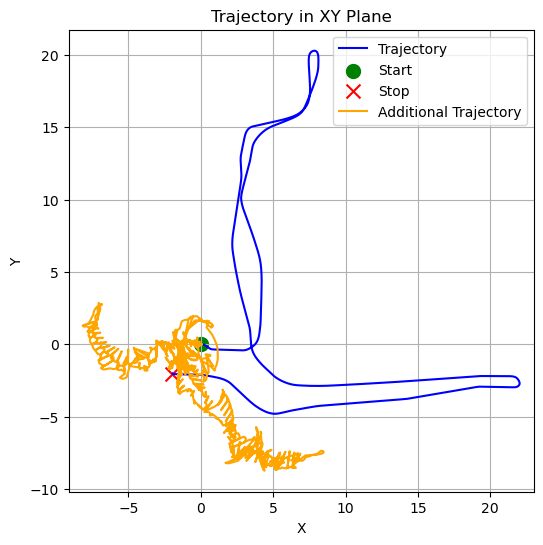

In [74]:
optimized_poses = []

for i in range(len(poses)):  # Iterate over all pose indices
    optimized_pose = result.atPose3(i)  # Get optimized Pose3
    T = np.eye(4)  # Initialize 4x4 matrix

    # Extract rotation and translation from Pose3
    T[:3, :3] = optimized_pose.rotation().matrix()
    T[:3, 3] = optimized_pose.translation()

    optimized_poses.append(T)

# Now, optimized_poses is a list of 4x4 matrices
optimized_poses= np.array(optimized_poses)
plot_trajectory(encoder_poses , optimized_poses)